# Broadband Internet Expansion for both Revenue and Equality in Tennessee

The notebook below details the data import, cleaning, and modeling used to predict broadband internet expansion opportunities in https://tn-broadband.herokuapp.com  
1. I import data for each census tract in TN from the US Census American Community Survey API. I then clean and preprocess the data, and display exploratory maps using geopandas. 
2. Following this I build a predictive model for households with broadband internet in each tract in TN using scikit-learn. I treat tracts with a large residual (many fewer actual houses with broadband than predicted) as those with the greatest opportunities to expand and capture new customers in the near term. 
3. Using the Python Spatial Analysis Library I further filter prime expansion locations down to those that are near other tracts with a high percentage of broadband. This lets us target areas near existing infrastructure for initial expansion.
4. Lastly, given that certain racial and ethnic minorities tend to have less household broadband, I examine which areas can both help a company expand to capture many new customers and simultaneously start to narrow gaps in broadband access.

## Data Import

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#import the census tract shapefile for TN, previously downloaded from US Census Bureau TIGER website
tracts=gpd.read_file("Shapefiles/Census Tracts 2019/tl_2019_47_tract.shp")

#tracts.head()

In [2]:
#create function to request all desired variables from US Census API and store them in a dataframe
#takes desired variables, dataset, and location
#outputs single dataframe with census tract rows and column for each variable

def call_API(year,dataset,variables,locations,data_types):
    
    #read person API access key
    with open('census_api_key.txt') as key_file:
        key=key_file.read().strip()
    
    #create API url
    variable_list=','.join(x for x in variables.keys())
    site='https://api.census.gov/data'
    url=f'{site}/{year}/{dataset}?get={variable_list}{locations}&key={key}'
    
    #get the API data
    import requests
    info=requests.get(url)
    
    #format dataframe
    data=info.json()
    df=pd.DataFrame(data[1:],columns=data[0]).rename(columns=variables)
    if 'tract' in df.columns: #only create GEOID column if calling API for tract data
        df['GEOID']=df.state+df.county+df.tract
    df=df.astype(dtype=data_types)
    
    return df
    

In [3]:
#List of desired variables to download from B-type tables using Census API
B_variables={'B01003_001E':'Total_Population',
            'B02001_002E':'White',
             'B02001_003E':'Black',
             'B02001_004E':'Am_Ind',
             'B02001_005E':'Asian',
             'B02001_006E':'Pac_Isl',
             'B02001_007E':'Other',
             'B02001_008E':'TwoPlusRaces',
            'B03002_012E':'Hispanic',
             'B03002_013E':'Hispanic_White',
             'B03002_014E':'Hispanic_Black',
             'B03002_015E':'Hispanic_Am_Ind',
             'B03002_016E':'Hispanic_Asian',
             'B03002_017E':'Hispanic_Pac_Isl',
             'B03002_018E':'Hispanic_Other',
             'B03002_019E':'Hispanic_TwoPlusRaces',
            'B25077_001E':'Median_Home_Value',
            'B25099_001E':'Median_Household_Income',
            'B28003_001E':'Households',
             'B28003_004E':'Broadband',
             'B28003_006E':'No_Computer'}

B_types={x:'int64' for x in B_variables.values()}

#Additional variables from S-type tables: Race of householder from census table S2502
S_variables={'S2502_C01_002E':'White_Householder',
              'S2502_C01_003E':'Black_Householder',
              'S2502_C01_004E':'Am_Ind_Householder',
              'S2502_C01_005E':'Asian_Householder',
              'S2502_C01_006E':'Pac_Isl_Householder',
              'S2502_C01_007E':'Other_Householder',
              'S2502_C01_008E':'Twoplus_Householder',
              'S2502_C01_009E':'Hispanic_Householder',
              'S2502_C01_010E':'White_Non_Hisp_Householder'}
S_types={x:'int64' for x in S_variables.values()}


In [4]:
#set Tennessee location for API call
location='&for=tract:*&in=state:47'

#obtain ACS census data from API call
census_df=call_API('2019','acs/acs5',B_variables,location,B_types)
S_data_frame=call_API('2019','acs/acs5/subject',S_variables,location,S_types)
census_df=census_df.merge(S_data_frame,on='GEOID',how='left')


## Data Processing

In [5]:
#merge census data with census tract geodataframe geometry
def merge_geographic_demographic(geographic_df,demographic_df):
    merged=geographic_df.merge(demographic_df,on='GEOID',how='left')
    return merged


In [6]:
#function to drop census tracts with spurious values
#odd values were identified through EDA (no people (airport for example), income -666million (placeholder?), etc)
def clean_tracts(df):
    cleaning_dict={'Total_Population':0,
                  'Median_Home_Value':-666666666,
                  'Median_Household_Income':-666666666,
                  'GEOID':'47037019300'  #outlier tract has very high income and very low property values? (Nissan Stadium + Cayce Homes)
                  } 
    new_df=df.copy()
    for var in cleaning_dict:
        new_df.drop(new_df.loc[new_df[var]==cleaning_dict[var]].index,inplace=True)
    return new_df


In [7]:
#create derived quantities as new variables
def add_derived_vars(df):
    new_df=df.copy()
    
    new_df['Pop_Density']=1000000*new_df.Total_Population/new_df.ALAND

    new_df['Pct_White']=100*new_df.White/new_df.Total_Population
    new_df['Pct_Black']=100*new_df.Black/new_df.Total_Population
    new_df['Pct_Am_Ind']=100*new_df.Am_Ind/new_df.Total_Population
    new_df['Pct_Asian']=100*new_df.Asian/new_df.Total_Population
    new_df['Pct_Pac_Isl']=100*new_df.Pac_Isl/new_df.Total_Population
    new_df['Pct_Other']=100*new_df.Other/new_df.Total_Population
    new_df['Pct_TwoPlusRaces']=100*new_df['TwoPlusRaces']/new_df.Total_Population
    new_df['Pct_AI+PI+O']=100*(new_df.Am_Ind+new_df.Pac_Isl+new_df.Other)/new_df.Total_Population
    new_df['Pct_AI+PI+O+2']=100*(new_df.Am_Ind+new_df.Pac_Isl+new_df.Other+new_df['TwoPlusRaces'])/new_df.Total_Population
    new_df['Pct_Non_White']=100-new_df.Pct_White

    new_df['Pct_Hispanic']=100*new_df.Hispanic/new_df.Total_Population
    new_df['Pct_White_Non_Hispanic']=100*(new_df.White-new_df['Hispanic_White'])/new_df.Total_Population
    new_df['Pct_Black_Non_Hispanic']=100*(new_df.Black-new_df['Hispanic_Black'])/new_df.Total_Population
    new_df['Pct_Am_Ind_Non_Hispanic']=100*(new_df.Am_Ind-new_df['Hispanic_Am_Ind'])/new_df.Total_Population
    new_df['Pct_Asian_Non_Hispanic']=100*(new_df.Asian-new_df['Hispanic_Asian'])/new_df.Total_Population
    new_df['Pct_Pac_Isl_Non_Hispanic']=100*(new_df.Pac_Isl-new_df['Hispanic_Pac_Isl'])/new_df.Total_Population
    new_df['Pct_Other_Non_Hispanic']=100*(new_df.Other-new_df['Hispanic_Other'])/new_df.Total_Population
    new_df['Pct_TwoPlusRaces_Non_Hispanic']=100*(new_df['TwoPlusRaces']-new_df['Hispanic_TwoPlusRaces'])/new_df.Total_Population

    new_df['Pct_Broadband']=100*new_df.Broadband/new_df.Households
    new_df['Pct_Computer']=100-100*new_df['No_Computer']/new_df.Households
    
    new_df['Pct_White_Householder']=100*new_df.White_Householder/new_df.Households
    new_df['Pct_Black_Householder']=100*new_df.Black_Householder/new_df.Households
    new_df['Pct_Am_Ind_Householder']=100*new_df.Am_Ind_Householder/new_df.Households
    new_df['Pct_Asian_Householder']=100*new_df.Asian_Householder/new_df.Households
    new_df['Pct_Pac_Isl_Householder']=100*new_df.Pac_Isl_Householder/new_df.Households
    new_df['Pct_Other_Householder']=100*new_df.Other_Householder/new_df.Households
    new_df['Pct_TwoPlusRaces_Householder']=100*new_df.Twoplus_Householder/new_df.Households
    new_df['Pct_Hispanic_Householder']=100*new_df.Hispanic_Householder/new_df.Households
    new_df['Pct_White_Non_Hispanic_Householder']=100*new_df['White_Non_Hisp_Householder']/new_df.Households
    
    return new_df


In [8]:
#conduct all preprocessing of tract geodataframe and demographic census dataframe
def preprocess(geographic_df,demographic_df):
    merged=merge_geographic_demographic(geographic_df,demographic_df)
    cleaned=clean_tracts(merged)
    derived_added=add_derived_vars(cleaned)
    
    #change coordinate reference system
    final=derived_added.to_crs(epsg=3857)
    
    return final

preprocessed=preprocess(tracts,census_df)
print(preprocessed.shape)
preprocessed.head()

(1452, 79)


,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,...,Pct_Computer,Pct_White_Householder,Pct_Black_Householder,Pct_Am_Ind_Householder,Pct_Asian_Householder,Pct_Pac_Isl_Householder,Pct_Other_Householder,Pct_TwoPlusRaces_Householder,Pct_Hispanic_Householder,Pct_White_Non_Hispanic_Householder
0,47,165,021002,47165021002,210.02,Census Tract 210.02,G5020,S,30654374,207994,...,92.455621,84.393491,12.906805,0.480769,1.368343,0.0,0.628698,0.221893,3.291420,81.952663
1,47,165,020901,47165020901,209.01,Census Tract 209.01,G5020,S,23811766,3412697,...,90.041494,88.381743,8.091286,0.000000,1.244813,0.0,2.282158,0.000000,2.282158,88.381743
2,47,165,020300,47165020300,203,Census Tract 203,G5020,S,14629292,0,...,91.635389,90.509383,4.235925,0.000000,0.643432,0.0,3.378016,1.233244,6.380697,87.506702
3,47,165,020902,47165020902,209.02,Census Tract 209.02,G5020,S,9756715,0,...,83.764219,80.489486,12.616339,0.000000,2.792141,0.0,3.343675,0.758359,8.790072,75.043089
4,47,165,020800,47165020800,208,Census Tract 208,G5020,S,10235406,37743,...,76.900826,46.487603,48.966942,0.000000,0.000000,0.0,4.090909,0.454545,12.520661,38.057851


## Exploratory Maps

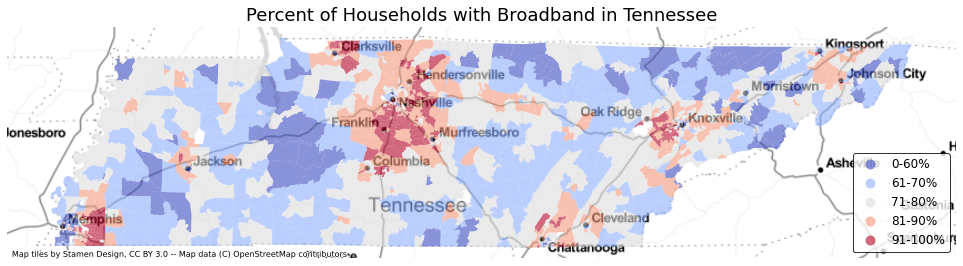

In [9]:
#create map of statewide broadband
import contextily as cx

bins=[60,70,80,90,100]
bin_labels=['0-60%','61-70%','71-80%','81-90%','91-100%']

f,ax=plt.subplots(1,figsize=(17,8))
preprocessed.plot(column='Pct_Broadband',scheme='User_Defined',ax=ax,classification_kwds={'bins':bins},
             legend=True,legend_kwds={'loc':'lower right','edgecolor':'k','labels':bin_labels,'fontsize':12},
             edgecolor='none',cmap='coolwarm',alpha=0.6)
cx.add_basemap(ax, crs=preprocessed.crs.to_string(), source=cx.providers.Stamen.TonerLite,zoom=7)
ax.set_axis_off()
ax.set_title('Percent of Households with Broadband in Tennessee',fontsize=18)
#plt.savefig('TN_Broadband',bbox_inches='tight',pad_inches=0)
plt.show()

In [10]:
#extract a dataframe of all tracts in a given county
def extract_county(df,county_string):
    state='47'  #Tennessee
    return df[df['GEOID'].str.match('^'+state+county_string)]

davidson=extract_county(preprocessed,'037')

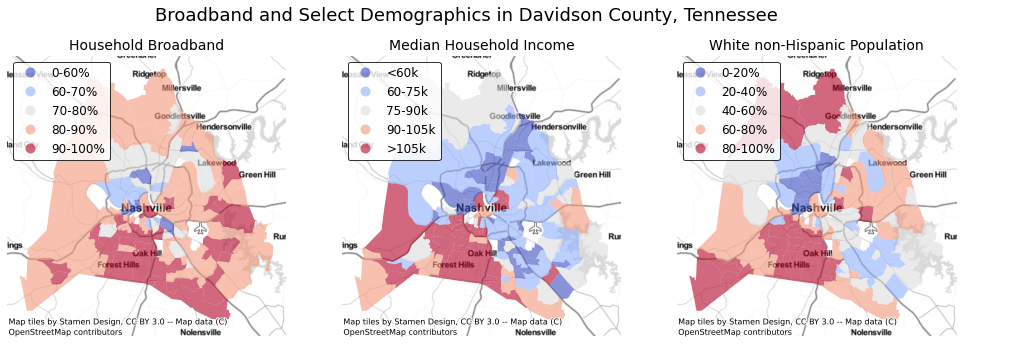

In [11]:
#create maps in Davidson County: broadband, income, percent white non-Hispanic population

def subplot_map(axes,gdf,col,bins,bin_labels,subtitle,cmap='coolwarm',edge='none'):
    gdf.plot(column=col,scheme='User_Defined',ax=axes,classification_kwds={'bins':bins},
                 legend=True,legend_kwds={'loc':'upper left','edgecolor':'k','labels':bin_labels,'fontsize':12},
                 edgecolor=edge,cmap=cmap,alpha=0.6)
    cx.add_basemap(axes, crs=gdf.crs.to_string(), source=cx.providers.Stamen.TonerLite,zoom=10)
    axes.set_axis_off()
    axes.set_title(subtitle,fontsize=14)
    return

f,ax=plt.subplots(1,3,figsize=(17,5.5))

bins=[60,70,80,90,100]
bin_labels=['0-60%','60-70%','70-80%','80-90%','90-100%']
subplot_map(ax[0],davidson,'Pct_Broadband',bins,bin_labels,'Household Broadband')

bins=[60000,75000,90000,105000,np.max(davidson['Median_Household_Income'])]
bin_labels=['<60k','60-75k','75-90k','90-105k','>105k']
subplot_map(ax[1],davidson,'Median_Household_Income',bins,bin_labels,'Median Household Income')

bins=[20,40,60,80,100]
bin_labels=['0-20%','20-40%','40-60%','60-80%','80-100%']
subplot_map(ax[2],davidson,'Pct_White_Non_Hispanic',bins,bin_labels,'White non-Hispanic Population')

f.suptitle('Broadband and Select Demographics in Davidson County, Tennessee',fontsize=18)
#plt.savefig('Davidson_factors',bbox_inches='tight',pad_inches=0)
plt.show()

## Modeling

In [12]:
#set GEOID as index, then split X from y
y=preprocessed.set_index('GEOID')['Pct_Broadband']
X=preprocessed.set_index('GEOID').drop(columns=['Pct_Broadband'])

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=2021,test_size=0.2)

#Note experimented with two random states for train/test split: first random_state=0, then random_state=2021.
#With random_state=0, much larger difference in train vs test R-squared for all models despite robust cross-validation,
#likely indicating an odd split in train and test values.


In [13]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV


#One function to perform modeling, for easy comparison of using different predictor columns and different model types.
#input: predictor columns to include, poly yes/no, regressor, CV dict of hyperparameter values to try
#returns: trained model, best hyperparameters from CV
def model_train(X_train, y_train, columns, regressor, cv_dict, poly_and_scale=True):
    
    col_trans=ColumnTransformer([('col','passthrough',columns)])
    
    if poly_and_scale:
        poly_trans=PolynomialFeatures(degree=2)
        scaler=StandardScaler()
        pipe=Pipeline([('col',col_trans),('poly',poly_trans),('scale',scaler),('regressor',regressor)])
    
    else:
        pipe=Pipeline([('col',col_trans),('regressor',regressor)])
    
    X_train_shuffle,y_train_shuffle=shuffle(X_train,y_train,random_state=0)
    
    grid_search=GridSearchCV(pipe,{'regressor__'+key:cv_dict[key] for key in cv_dict},cv=5)
    model=grid_search.fit(X_train_shuffle,y_train_shuffle)
    best_performance=(grid_search.best_params_,grid_search.best_score_)
    
    return model, best_performance
        

In [14]:
#print train/test scores for models
def print_scores(base_model, base_best_params, X_train, y_train, X_test, y_test, model_type):
    print('Train R-squared baseline model ({}): {:.3f}'.format(model_type,base_model.score(X_train,y_train)))
    print('Test R-squared baseline model ({}): {:.3f}'.format(model_type,base_model.score(X_test,y_test)))
    print('Best parameters from CV: '+str(base_best_params))
    print()
    return

In [15]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor


baseline_columns=['Pop_Density','Median_Household_Income','Median_Home_Value','Pct_Computer']

####
#knn model

knn_hyperparameter_cv={'n_neighbors':[10,20,30,40,50]}

knn_baseline, knn_best_baseline= model_train(X_train, y_train, baseline_columns, 
                                                     KNeighborsRegressor(), 
                                                     knn_hyperparameter_cv,
                                                    poly_and_scale=False)

print_scores(knn_baseline, knn_best_baseline, X_train, y_train, X_test, y_test, 'KNN')

####
#ridge model

ridge_hyperparameter_cv={'alpha':np.logspace(-1,2,num=25)}

ridge_baseline, ridge_best_baseline= model_train(X_train, y_train, baseline_columns, Ridge(), 
                                                 ridge_hyperparameter_cv)

print_scores(ridge_baseline, ridge_best_baseline, X_train, y_train, X_test, y_test, 'Ridge')

####
#lasso model

lasso_hyperparameter_cv={'alpha':[0.001,0.005,0.01,0.05,0.1,0.2,0.5,1,2,3,5,7,10]}

lasso_baseline, lasso_best_baseline= model_train(X_train, y_train, baseline_columns, Lasso(max_iter=100000), 
                                                 lasso_hyperparameter_cv)

print_scores(lasso_baseline, lasso_best_baseline, X_train, y_train, X_test, y_test, 'Lasso')

####
#random forest model

randfor_hyperparameter_cv={'max_depth':[2,3,5,7,10,12,15],
                          'min_samples_leaf':[1,3,5,10,20]}

randfor_baseline, randfor_best_baseline= model_train(X_train, y_train, baseline_columns, 
                                                     RandomForestRegressor(n_estimators=50), 
                                                     randfor_hyperparameter_cv,
                                                    poly_and_scale=False)


print_scores(randfor_baseline, randfor_best_baseline, X_train, y_train, X_test, y_test, 'Random Forest')



Train R-squared baseline model (KNN): 0.649
Test R-squared baseline model (KNN): 0.686
Best parameters from CV: ({'regressor__n_neighbors': 30}, 0.6131496504378315)

Train R-squared baseline model (Ridge): 0.876
Test R-squared baseline model (Ridge): 0.904
Best parameters from CV: ({'regressor__alpha': 0.31622776601683794}, 0.8698413612882312)

Train R-squared baseline model (Lasso): 0.875
Test R-squared baseline model (Lasso): 0.905
Best parameters from CV: ({'regressor__alpha': 0.005}, 0.8699870431290433)

Train R-squared baseline model (Random Forest): 0.930
Test R-squared baseline model (Random Forest): 0.910
Best parameters from CV: ({'regressor__max_depth': 7, 'regressor__min_samples_leaf': 1}, 0.8680543564620689)



Selecting random forest model for further use: highest performance on test dataset of all tested model types

## Generate predictions for all tracts

In [16]:
#create the dataframe for predictions
tn_preds=preprocessed.copy()
base_pred= randfor_baseline.predict(preprocessed.set_index('GEOID').drop(columns=['Pct_Broadband']))
tn_preds['Base_Pred_Pct_Broadband']=base_pred
tn_preds['Residual_Broadband']=tn_preds['Pct_Broadband']-tn_preds['Base_Pred_Pct_Broadband']


In [17]:
tn_preds['Pred_New_BB_Households']=((-1)*tn_preds['Residual_Broadband']/100*
                                           tn_preds['Households'])

In [18]:
#Consistent with national trends and my own modeling in TN from another project, will consider underrepresented groups
#with respect to broadband those that are not White Non-Hispanic and not Asian
tn_preds['Pct_Underrep_BB_Households']=(100-tn_preds['Pct_White_Non_Hispanic_Householder']-
                                            tn_preds['Pct_Asian_Householder'])

tn_preds['Pred_New_BB_Underrep_Households']=(tn_preds['Pred_New_BB_Households']*
                                            tn_preds['Pct_Underrep_BB_Households']/100)

In [19]:
import libpysal
from libpysal.weights import Rook

rw_tn=Rook.from_dataframe(tn_preds,idVariable='GEOID')
#using Rook weights to find which tracts are adjacent to each other (tracts adjoin each other along an edge)

median_broadband=np.median(preprocessed['Pct_Broadband'])
tn_high_bb_tracts=tn_preds[tn_preds['Pct_Broadband']>median_broadband]['GEOID'].tolist()
#an arbitrary selection for now, but "high broadband" tracts are those with Pct_Broadband over the state median for all TN tracts

def tracts_and_neighbors(tracts,weights):
    neighbors=[]
    for tract in tracts:
        neighbors.extend(weights.neighbors[tract])
    neighbors.extend(tracts)
    neighbors=list(set(neighbors))
    return neighbors

tenn_t_and_n=tracts_and_neighbors(tn_high_bb_tracts,rw_tn)
tn_preds['Neighbor_High_BB']=tn_preds['GEOID'].isin(tenn_t_and_n)

tn_preds['Pred_New_BB_HH_Neighbor_High']=(tn_preds['Neighbor_High_BB']*
                                          tn_preds['Pred_New_BB_Households'])

tn_preds['Pred_New_BB_Underrep_HH_Neighbor_High']=(tn_preds['Neighbor_High_BB']*
                                                   tn_preds['Pred_New_BB_Underrep_Households'])

In [20]:
#create the dataframe that will be exported to the web app
tn_map_df=tn_preds[['COUNTYFP','GEOID','geometry','Pop_Density','Median_Household_Income','Median_Home_Value',
                    'Pct_White_Non_Hispanic','Pct_Black_Non_Hispanic','Pct_Am_Ind_Non_Hispanic',
                    'Pct_Asian_Non_Hispanic','Pct_Pac_Isl_Non_Hispanic','Pct_Other_Non_Hispanic',
                    'Pct_TwoPlusRaces_Non_Hispanic','Pct_Hispanic',
                    'Pct_Broadband','Pct_Computer',
                   'Pred_New_BB_Households','Pred_New_BB_Underrep_Households',
                   'Pred_New_BB_HH_Neighbor_High','Pred_New_BB_Underrep_HH_Neighbor_High']].copy()

#adjust predictions where we only plot positive values (number of new broadband households in a tract, etc.)
factors_positive=['Pred_New_BB_Households','Pred_New_BB_HH_Neighbor_High',
                  'Pred_New_BB_Underrep_Households','Pred_New_BB_Underrep_HH_Neighbor_High']
for f in factors_positive:
    tn_map_df[f]=[x if x>0 else 0 for x in tn_map_df[f]]

#change format of county label column
tn_map_df['COUNTYFP']=[int(s) for s in tn_map_df['COUNTYFP']]

#uncomment line below to export dataframe to pickle file for web app to use
#tn_map_df.to_pickle('./map_df_tn.pkl')

## Example plots in Davidson County

In [21]:
davidson_w_preds=extract_county(tn_preds,'037')

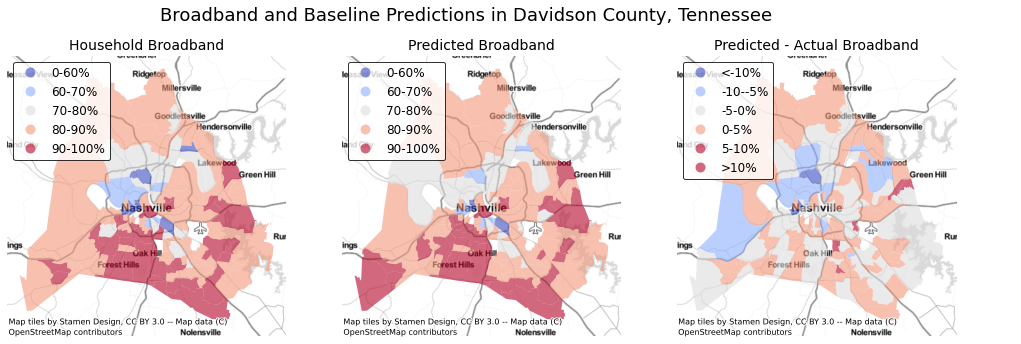

In [22]:

f,ax=plt.subplots(1,3,figsize=(17,5.5))

bins=[60,70,80,90,100]
bin_labels=['0-60%','60-70%','70-80%','80-90%','90-100%']
subplot_map(ax[0],davidson_w_preds,'Pct_Broadband',bins,bin_labels,'Household Broadband')

subplot_map(ax[1],davidson_w_preds,'Base_Pred_Pct_Broadband',bins,bin_labels,'Predicted Broadband')

bins=[-10,-5,0,5,10,100]
bin_labels=['<-10%','-10--5%','-5-0%','0-5%','5-10%','>10%']
subplot_map(ax[2],davidson_w_preds,'Residual_Broadband',bins,bin_labels,'Predicted - Actual Broadband')

f.suptitle('Broadband and Baseline Predictions in Davidson County, Tennessee',fontsize=18)
#plt.savefig('Davidson_Broadband_Predictions',bbox_inches='tight',pad_inches=0)
plt.show()

In [23]:
def make_bins(series, step=100):
    maximum=int(np.ceil(np.max(series)))
    bins=[*range(0,maximum,step)]+[maximum]
    bin_labels=[bins[0]]
    for i in range(1,len(bins)):
        bin_labels.append('{}-{}'.format(bins[i-1]+1,bins[i]))
    return bins,bin_labels

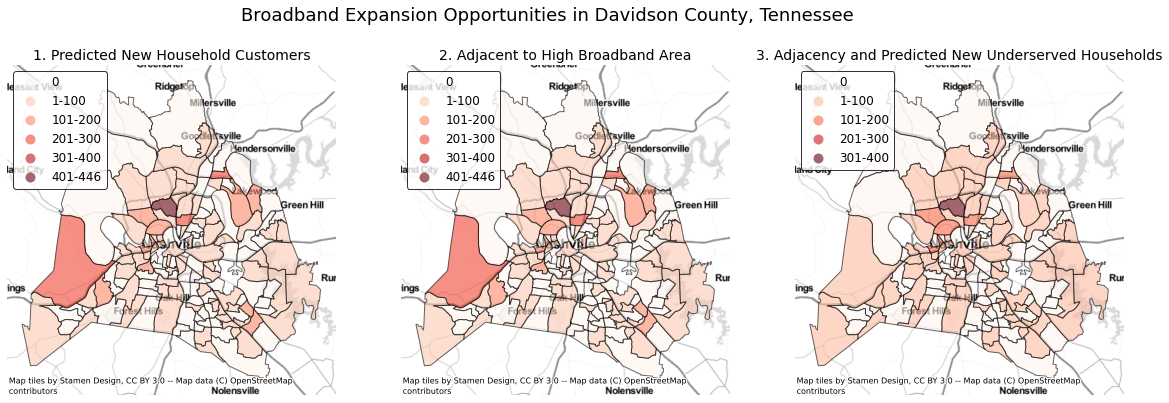

In [24]:
f,ax=plt.subplots(1,3,figsize=(20,6.5))

bins,bin_labels=make_bins(davidson_w_preds['Pred_New_BB_Households'])
subplot_map(ax[0],davidson_w_preds,'Pred_New_BB_Households',bins,bin_labels,
            '1. Predicted New Household Customers',cmap='Reds',edge='k')


bins,bin_labels=make_bins(davidson_w_preds['Pred_New_BB_HH_Neighbor_High'])
subplot_map(ax[1],davidson_w_preds,'Pred_New_BB_HH_Neighbor_High',bins,bin_labels,
            '2. Adjacent to High Broadband Area',cmap='Reds',edge='k')

bins,bin_labels=make_bins(davidson_w_preds['Pred_New_BB_Underrep_HH_Neighbor_High'])
subplot_map(ax[2],davidson_w_preds,'Pred_New_BB_Underrep_HH_Neighbor_High',bins,bin_labels,
            '3. Adjacency and Predicted New Underserved Households',cmap='Reds',edge='k')

f.suptitle('Broadband Expansion Opportunities in Davidson County, Tennessee',fontsize=18)
#plt.savefig('Davidson_Expansion_Opps',bbox_inches='tight',pad_inches=0)
plt.show()

Estimating new annual revenue possible in Davidson County

In [25]:
#estimating annual revenue from one household subscription
annual_revenue_household=50*12

#also est for all groups
new_rev=np.sum(davidson_w_preds['Pred_New_BB_Households'][davidson_w_preds['Pred_New_BB_Households']>0])*annual_revenue_household
new_rev_underrep=np.sum(davidson_w_preds['Pred_New_BB_Underrep_HH_Neighbor_High'][davidson_w_preds['Pred_New_BB_Underrep_HH_Neighbor_High']>0])*annual_revenue_household

print('New annual revenue opportunity in Davidson County, all groups: ${:,.0f}'.format(new_rev))
print('New annual revenue opportunity in Davidson County, underserved groups: ${:,.0f}'.format(new_rev_underrep))

New annual revenue opportunity in Davidson County, all groups: $2,802,818
New annual revenue opportunity in Davidson County, underserved groups: $1,532,834


## Supporting plots for web app

Make model performance plot

In [26]:
#increase plot font size
plt.rc('font',size=15)

#function to format plot axis style
def plot_style(ax):
    ax.spines['bottom'].set_color('grey')
    ax.spines['left'].set_color('grey')
    ax.tick_params(axis='x', color='grey', labelcolor='dimgrey')
    ax.tick_params(axis='y', color='grey', labelcolor='dimgrey')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    return

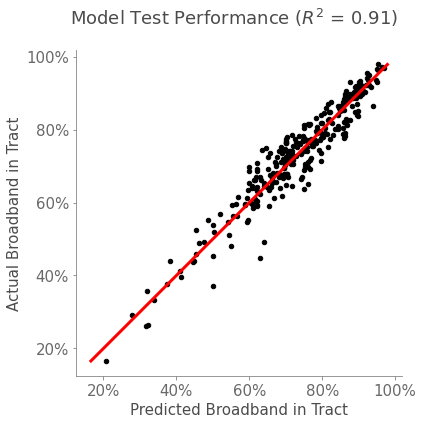

In [27]:
f,ax=plt.subplots(figsize=(6,6))
plt.plot([min(y_test),max(y_test)],[min(y_test),max(y_test)],color='r',linewidth=3)
plt.scatter(randfor_baseline.predict(X_test),y_test,color='k',s=20)


#edit axes
plot_style(ax)
ax.set_aspect('equal',adjustable='box')

#labels
ax.set_xlabel('Predicted Broadband in Tract',alpha=0.7)
ax.set_ylabel('Actual Broadband in Tract',alpha=0.7)
intervals=[20,40,60,80,100]
ax.xaxis.set_ticks(intervals)
ax.yaxis.set_ticks(intervals)
import matplotlib.ticker as tkr
ax.get_xaxis().set_major_formatter(tkr.StrMethodFormatter('{x:.0f}%'))
ax.get_yaxis().set_major_formatter(tkr.StrMethodFormatter('{x:.0f}%'))

r_squared=randfor_baseline.score(X_test,y_test)
f.suptitle('Model Test Performance ($R^2$ = {:.2f})'.format(r_squared),fontsize=18,alpha=0.7)

#plt.savefig('Predicted_vs_Actual',bbox_inches='tight',pad_inches=0.2)

plt.show()

Make plot showing interaction of race and household broadband

In [28]:
#function to plot interaction between two factors and predicted variable
def interaction_plot(X,y,factor1,factor2,xlabel,ylabel,clabel,f1_format='{x:.0f}%',f2_format='${x:,.0f}',title=None,save_name=None):
    
    f,ax=plt.subplots(1,figsize=(10,6))
    plt.scatter(X[factor1],X[factor2],c=y,cmap='coolwarm_r',alpha=0.8);
    c=plt.colorbar();

    #edit axes
    plot_style(ax)
    c.ax.tick_params(axis='y', color='grey', labelcolor='dimgrey')
    c.outline.set_edgecolor('grey')
    import matplotlib.ticker as tkr
    ax.get_xaxis().set_major_formatter(tkr.StrMethodFormatter(f1_format))
    ax.get_yaxis().set_major_formatter(tkr.StrMethodFormatter(f2_format))

    #labels
    ax.set_xlabel(xlabel,alpha=0.7)
    ax.set_ylabel(ylabel,alpha=0.7)
    c.set_label(clabel, alpha=0.7)

    if title:
        f.suptitle(title,fontsize=18, alpha=0.7)
    if save_name:
        plt.savefig(save_name,bbox_inches='tight',pad_inches=0)
    
    plt.show()
    
    return

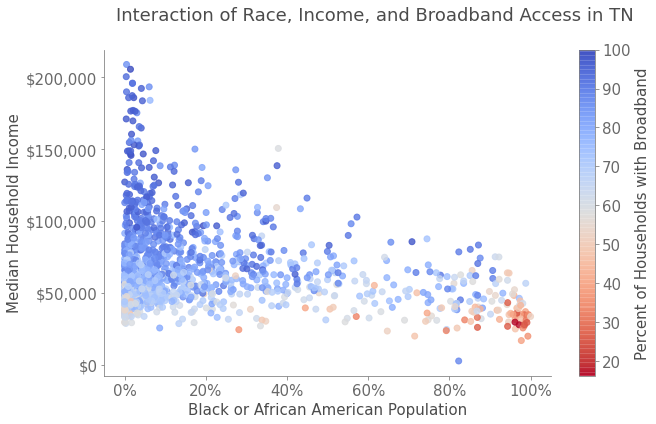

In [29]:
#make and save select interaction plots
pairs=[('Pct_Black','Median_Household_Income')]

titles={('Pct_Black_Non_Hispanic','Median_Household_Income'):'Interaction of Black Population, Income, and Broadband Access in TN',
       ('Pct_Black','Median_Household_Income'):'Interaction of Race, Income, and Broadband Access in TN'}
save_names={('Pct_Black_Non_Hispanic','Median_Household_Income'):'Black_Non_Hisp_Income_Broadband',
           ('Pct_Black','Median_Household_Income'):'Black_Income_Broadband'}

factor_labels={'Median_Household_Income':'Median Household Income',
        'Pct_Black_Non_Hispanic':'Black non-Hispanic Population',
        'Pct_Black':'Black or African American Population',
        'Pct_White_Non_Hispanic':'White non-Hispanic Population',
        'Pct_Hispanic':'Hispanic Population'}
factor_format={'Median_Household_Income':'${x:,.0f}',
        'Pct_Black_Non_Hispanic':'{x:.0f}%',
        'Pct_Black':'{x:.0f}%',
        'Pct_White_Non_Hispanic':'{x:.0f}%',
        'Pct_Hispanic':'{x:.0f}%'}

for p in pairs:
    interaction_plot(X,y,p[0],p[1],factor_labels[p[0]],factor_labels[p[1]],'Percent of Households with Broadband',
                     f1_format=factor_format[p[0]],f2_format=factor_format[p[1]],title=titles[tuple(p)])#,save_name=save_names[tuple(p)])